In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
import zipfile
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
zf = zipfile.ZipFile('../data/test.csv.zip')
zf.extract('test.csv', path='../data')
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
y_test, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

## Do your thing crazy machine learning thing here :) ...

### Exploratory data analysis

In [3]:
miss_values_tr = len(tX[tX==-999])
miss_values_te = len(tX_test[tX_test==-999])
print('There are {a} data points and {b} features in the training data.'.format(a=tX.shape[0], b=tX.shape[1]))
print('There are {a} missing values for a total number of {b} values in the training data. -> {c}% are missing values'.format(a=miss_values_tr, b=tX.shape[0]*tX.shape[1], c = 100*miss_values_tr/(tX.shape[0]*tX.shape[1])))
print('There are {a} missing values for a total number of {b} values in the test data. -> {c}% are missing values'.format(a=miss_values_te, b=tX_test.shape[0]*tX_test.shape[1], c = 100*miss_values_te/(tX_test.shape[0]*tX_test.shape[1])))

There are 250000 data points and 30 features in the training data.
There are 1580052 missing values for a total number of 7500000 values in the training data. -> 21.06736% are missing values
There are 3588434 missing values for a total number of 17047140 values in the test data. -> 21.050064702935508% are missing values


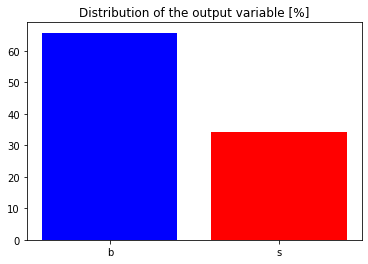

In [4]:
s = np.sum(y)
b = len(y) - s
tot = len(y)
labels =  [(b/tot)*100, (s/tot)*100]
plt.bar(['b', 's'], labels, color = ['b', 'r'])
plt.title("Distribution of the output variable [%]")
plt.show()

### Preprocessing

In [5]:
from data_processing import*
train_tx, train_y, val_tx, val_y, test_tx, test_y = preprocessing(tX, y, tX_test, y_test)

## Feature selection

In [6]:
import pandas as pd
import seaborn as sns

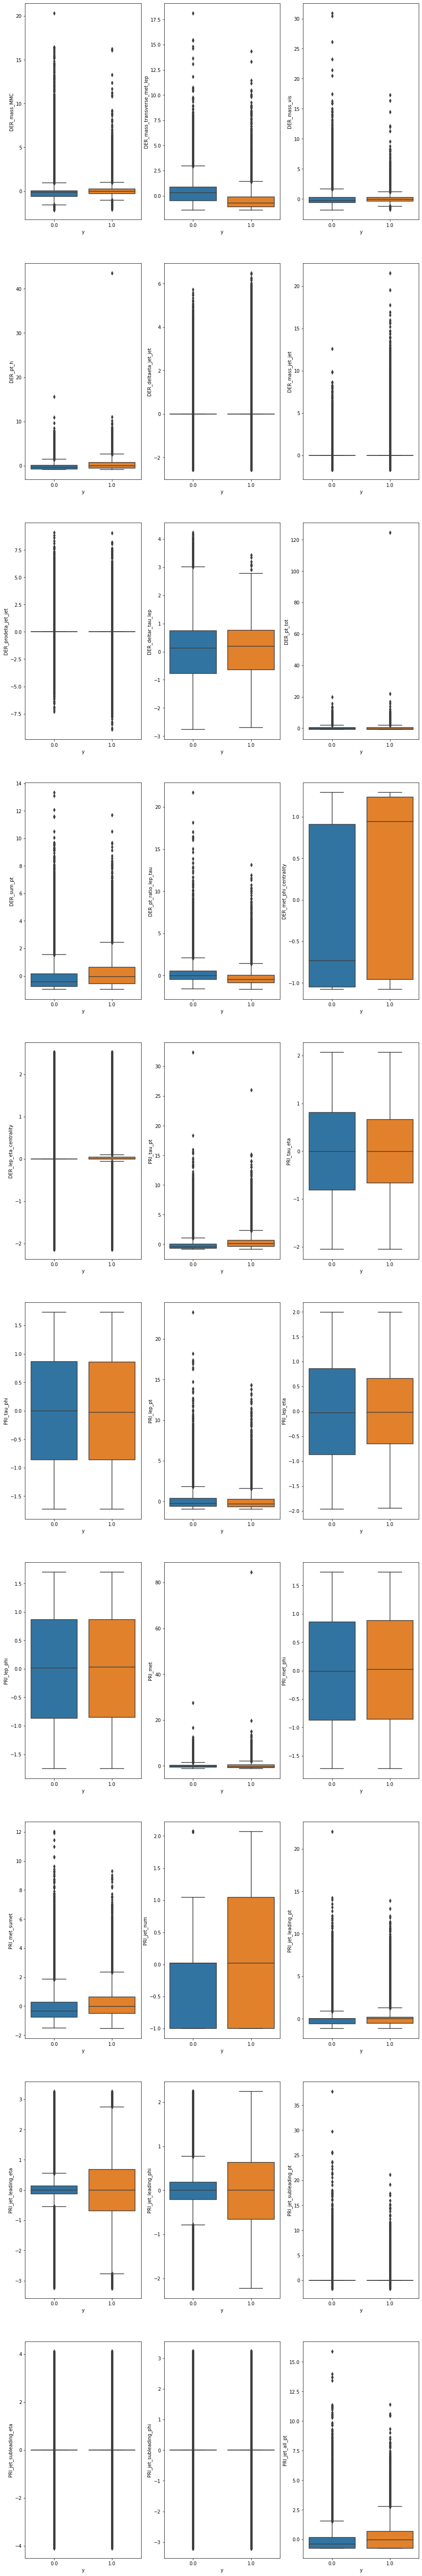

In [7]:
names = np.genfromtxt(DATA_TRAIN_PATH, delimiter=",", names=True, dtype=str).dtype.names
df_mean = pd.DataFrame(train_tx[:,1:], columns = np.array(names[2:]))
df_mean['y'] = train_y[:]

col = np.ravel(np.indices((3, 10))[0].T)
row = np.ravel(np.indices((3, 10))[1].T)
fig, axs = plt.subplots(ncols=3, nrows=len(names[2:])//3, figsize=(15,100))
for i in range(len(names[2:])):
    sns.boxplot(x = 'y', y = names[i+2], data = df_mean, ax = axs[row[i],col[i]])

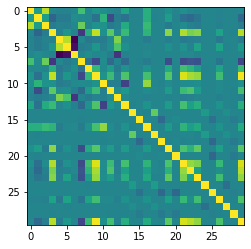

In [8]:
coeff_matrix = np.corrcoef(train_tx[:,1:].T)
ax = plt.imshow(coeff_matrix)

In [9]:
train_tx = np.delete(train_tx, [10, 16, 19, 21, 22], 1)
val_tx = np.delete(val_tx, [10, 16, 19, 21, 22], 1)
test_tx = np.delete(test_tx, [10, 16, 19, 21, 22], 1)

### Cross-validation

Parameters definition for all the cross validations and spliting of the data in k (=?) folds

In [10]:
from cross_validation import*

seed = 1
k_fold = 5

max_iters = [50, 100, 150, 200]
gammas = np.logspace(-4, 0, 30)
lambdas = np.logspace(-4, 0, 30)

# split data in k fold
k_indices = build_k_indices(train_y, k_fold, seed)

#### Gradient descent

In [11]:
# define lists to store the loss of training data and test data
rmse_tr = np.zeros((len(max_iters), len(gammas)))
rmse_te = np.zeros((len(max_iters), len(gammas)))
acc_tr = np.zeros((len(max_iters), len(gammas)))
acc_te = np.zeros((len(max_iters), len(gammas)))
# compute loss for each lambda is lambdas
for i, max_iter in enumerate(max_iters):
    for j, gamma in enumerate(gammas):
        rmse_tr_tmp = []
        rmse_te_tmp = []
        acc_tr_tmp = []
        acc_te_tmp = []
        for k in range(k_fold):
            loss_tr, loss_te, accuracy = cv_GD(train_y, train_tx, k_indices, k, max_iter, gamma)
            rmse_tr_tmp.append(loss_tr)
            rmse_te_tmp.append(loss_te)
            acc_tr_tmp.append(accuracy[0])
            acc_te_tmp.append(accuracy[1])
            

        rmse_tr[i, j] = np.mean(rmse_tr_tmp)
        rmse_te[i, j] = np.mean(rmse_te_tmp)
        acc_tr[i, j] = np.mean(acc_tr_tmp)
        acc_te[i, j] = np.mean(acc_te_tmp)

In [12]:
# Index of min/max error/accuracy
i_rmse_tr = np.unravel_index(rmse_tr.argmin(), rmse_tr.shape)
i_rmse_te = np.unravel_index(rmse_te.argmin(), rmse_te.shape)
i_acc_tr = np.unravel_index(acc_tr.argmax(), acc_tr.shape)
i_acc_te = np.unravel_index(acc_te.argmax(), acc_te.shape)

# Values of min/max error/accuracy
rmse_tr_min = rmse_tr[i_rmse_tr[0], i_rmse_tr[1]]
rmse_te_min = rmse_te[i_rmse_te[0], i_rmse_te[1]]
acc_tr_max = acc_tr[i_acc_tr[0], i_acc_tr[1]]
acc_te_max = acc_te[i_acc_te[0], i_acc_te[1]]

# Print results
print('minimum train rmse: {rmse_tr_min}. max_iter = {max_i}, gamma = {g}. ' 
      .format(rmse_tr_min = rmse_tr_min, max_i = max_iters[i_rmse_tr[0]], g = gammas[i_rmse_tr[1]]))
print('minimum test rmse: {rmse_te_min}. max_iter = {max_i}, gamma = {g}. ' 
      .format(rmse_te_min = rmse_te_min, max_i = max_iters[i_rmse_te[0]], g = gammas[i_rmse_te[1]]))
print('maximum train accuracy: {acc_tr_max}. max_iter = {max_i}, gamma = {g}. ' 
      .format(acc_tr_max = acc_tr_max, max_i = max_iters[i_acc_tr[0]], g = gammas[i_acc_tr[1]]))
print('maximum test accuracy: {acc_te_max}. max_iter = {max_i}, gamma = {g}. ' 
      .format(acc_te_max = acc_te_max, max_i = max_iters[i_acc_te[0]], g = gammas[i_acc_te[1]]))

minimum train rmse: 0.41272957547012845. max_iter = 200, gamma = 0.38566204211634725. 
minimum test rmse: 0.41272822224982064. max_iter = 200, gamma = 0.38566204211634725. 
maximum train accuracy: 0.7441600000000002. max_iter = 150, gamma = 0.2807216203941176. 
maximum test accuracy: 0.7441599999999999. max_iter = 150, gamma = 0.2807216203941176. 


#### Stochastic Gradient Descent

In [13]:
# define lists to store the loss of training data and test data
rmse_tr = np.zeros((len(max_iters), len(gammas)))
rmse_te = np.zeros((len(max_iters), len(gammas)))
acc_tr = np.zeros((len(max_iters), len(gammas)))
acc_te = np.zeros((len(max_iters), len(gammas)))
# compute loss for each lambda is lambdas
for i, max_iter in enumerate(max_iters):
    for j, gamma in enumerate(gammas):
        rmse_tr_tmp = []
        rmse_te_tmp = []
        acc_tr_tmp = []
        acc_te_tmp = []
        for k in range(k_fold):
            loss_tr, loss_te, accuracy = cv_SGD(train_y, train_tx, k_indices, k, max_iter, gamma)
            rmse_tr_tmp.append(loss_tr)
            rmse_te_tmp.append(loss_te)
            acc_tr_tmp.append(accuracy[0])
            acc_te_tmp.append(accuracy[1])
            

        rmse_tr[i, j] = np.mean(rmse_tr_tmp)
        rmse_te[i, j] = np.mean(rmse_te_tmp)
        acc_tr[i, j] = np.mean(acc_tr_tmp)
        acc_te[i, j] = np.mean(acc_te_tmp)

In [14]:
# Index of min/max error/accuracy
i_rmse_tr = np.unravel_index(rmse_tr.argmin(), rmse_tr.shape)
i_rmse_te = np.unravel_index(rmse_te.argmin(), rmse_te.shape)
i_acc_tr = np.unravel_index(acc_tr.argmax(), acc_tr.shape)
i_acc_te = np.unravel_index(acc_te.argmax(), acc_te.shape)

# Values of min/max error/accuracy
rmse_tr_min = rmse_tr[i_rmse_tr[0], i_rmse_tr[1]]
rmse_te_min = rmse_te[i_rmse_te[0], i_rmse_te[1]]
acc_tr_max = acc_tr[i_acc_tr[0], i_acc_tr[1]]
acc_te_max = acc_te[i_acc_te[0], i_acc_te[1]]

# Print results
print('minimum train rmse: {rmse_tr_min}. max_iter = {max_i}, gamma = {g}. ' 
      .format(rmse_tr_min = rmse_tr_min, max_i = max_iters[i_rmse_tr[0]], g = gammas[i_rmse_tr[1]]))
print('minimum test rmse: {rmse_te_min}. max_iter = {max_i}, gamma = {g}. ' 
      .format(rmse_te_min = rmse_te_min, max_i = max_iters[i_rmse_te[0]], g = gammas[i_rmse_te[1]]))
print('maximum train accuracy: {acc_tr_max}. max_iter = {max_i}, gamma = {g}. ' 
      .format(acc_tr_max = acc_tr_max, max_i = max_iters[i_acc_tr[0]], g = gammas[i_acc_tr[1]]))
print('maximum test accuracy: {acc_te_max}. max_iter = {max_i}, gamma = {g}. ' 
      .format(acc_te_max = acc_te_max, max_i = max_iters[i_acc_te[0]], g = gammas[i_acc_te[1]]))

minimum train rmse: 0.45261880719287007. max_iter = 200, gamma = 0.006210169418915616. 
minimum test rmse: 0.45248938425370017. max_iter = 200, gamma = 0.006210169418915616. 
maximum train accuracy: 0.7037171428571429. max_iter = 200, gamma = 0.011721022975334805. 
maximum test accuracy: 0.7030342857142857. max_iter = 200, gamma = 0.011721022975334805. 


#### Ridge regression

In [15]:
# define lists to store the loss of training data and test data
rmse_tr = np.zeros(len(gammas))
rmse_te = np.zeros(len(gammas))
acc_tr = np.zeros(len(gammas))
acc_te = np.zeros(len(gammas))
# compute loss for each lambda is lambdas
for i, lambda_ in enumerate(lambdas):
    rmse_tr_tmp = []
    rmse_te_tmp = []
    acc_tr_tmp = []
    acc_te_tmp = []
    for k in range(k_fold):
        loss_tr, loss_te, accuracy = cv_ridge_regression(train_y, train_tx, k_indices, k, lambda_)
        rmse_tr_tmp.append(loss_tr)
        rmse_te_tmp.append(loss_te)
        acc_tr_tmp.append(accuracy[0])
        acc_te_tmp.append(accuracy[1])


    rmse_tr[i] = np.mean(rmse_tr_tmp)
    rmse_te[i] = np.mean(rmse_te_tmp)
    acc_tr[i] = np.mean(acc_tr_tmp)
    acc_te[i] = np.mean(acc_te_tmp)

In [16]:
# Index of min/max error/accuracy
i_rmse_tr = rmse_tr.argmin()
i_rmse_te = rmse_te.argmin()
i_acc_tr = acc_tr.argmax()
i_acc_te = acc_te.argmax()

# Values of min/max error/accuracy
rmse_tr_min = rmse_tr[i_rmse_tr]
rmse_te_min = rmse_te[i_rmse_te]
acc_tr_max = acc_tr[i_acc_tr]
acc_te_max = acc_te[i_acc_te]

# Print results
print('minimum train rmse: {rmse_tr_min}. gamma = {g}. ' 
      .format(rmse_tr_min = rmse_tr_min, g = lambdas[i_rmse_tr]))
print('minimum test rmse: {rmse_te_min}. gamma = {g}. ' 
      .format(rmse_te_min = rmse_te_min, g = lambdas[i_rmse_te]))
print('maximum train accuracy: {acc_tr_max}. gamma = {g}. ' 
      .format(acc_tr_max = acc_tr_max, g = lambdas[i_acc_tr]))
print('maximum test accuracy: {acc_te_max}. gamma = {g}. ' 
      .format(acc_te_max = acc_te_max, g = lambdas[i_acc_te]))

minimum train rmse: 0.41272023290926085. gamma = 0.0001. 
minimum test rmse: 0.41279995563148547. gamma = 0.00018873918221350977. 
maximum train accuracy: 0.7440985714285715. gamma = 0.0001. 
maximum test accuracy: 0.7440800000000001. gamma = 0.0001. 


#### Logistic regression

In [17]:
# define lists to store the loss of training data and test data
rmse_tr = np.zeros((len(max_iters), len(gammas)))
rmse_te = np.zeros((len(max_iters), len(gammas)))
acc_tr = np.zeros((len(max_iters), len(gammas)))
acc_te = np.zeros((len(max_iters), len(gammas)))
# compute loss for each max_iter and gamma
for i, max_iter in enumerate(max_iters):
    for j, gamma in enumerate(gammas):
        rmse_tr_tmp = []
        rmse_te_tmp = []
        acc_tr_tmp = []
        acc_te_tmp = []
        for k in range(k_fold):
            loss_tr, loss_te, accuracy = cv_logistic_regression(train_y, train_tx, k_indices, k, max_iter, gamma)
            rmse_tr_tmp.append(loss_tr)
            rmse_te_tmp.append(loss_te)
            acc_tr_tmp.append(accuracy[0])
            acc_te_tmp.append(accuracy[1])
            

        rmse_tr[i, j] = np.mean(rmse_tr_tmp)
        rmse_te[i, j] = np.mean(rmse_te_tmp)
        acc_tr[i, j] = np.mean(acc_tr_tmp)
        acc_te[i, j] = np.mean(acc_te_tmp)

In [18]:
# Index of min/max error/accuracy
i_rmse_tr = np.unravel_index(rmse_tr.argmin(), rmse_tr.shape)
i_rmse_te = np.unravel_index(rmse_te.argmin(), rmse_te.shape)
i_acc_tr = np.unravel_index(acc_tr.argmax(), acc_tr.shape)
i_acc_te = np.unravel_index(acc_te.argmax(), acc_te.shape)

# Values of min/max error/accuracy
rmse_tr_min = rmse_tr[i_rmse_tr[0], i_rmse_tr[1]]
rmse_te_min = rmse_te[i_rmse_te[0], i_rmse_te[1]]
acc_tr_max = acc_tr[i_acc_tr[0], i_acc_tr[1]]
acc_te_max = acc_te[i_acc_te[0], i_acc_te[1]]

# Print results
print('minimum train rmse: {rmse_tr_min}. max_iter = {max_i}, gamma = {g}. ' 
      .format(rmse_tr_min = rmse_tr_min, max_i = max_iters[i_rmse_tr[0]], g = gammas[i_rmse_tr[1]]))
print('minimum test rmse: {rmse_te_min}. max_iter = {max_i}, gamma = {g}. ' 
      .format(rmse_te_min = rmse_te_min, max_i = max_iters[i_rmse_te[0]], g = gammas[i_rmse_te[1]]))
print('maximum train accuracy: {acc_tr_max}. max_iter = {max_i}, gamma = {g}. ' 
      .format(acc_tr_max = acc_tr_max, max_i = max_iters[i_acc_tr[0]], g = gammas[i_acc_tr[1]]))
print('maximum test accuracy: {acc_te_max}. max_iter = {max_i}, gamma = {g}. ' 
      .format(acc_te_max = acc_te_max, max_i = max_iters[i_acc_te[0]], g = gammas[i_acc_te[1]]))

minimum train rmse: 11.826627414473759. max_iter = 50, gamma = 0.0001. 
minimum test rmse: 11.826321530972333. max_iter = 50, gamma = 0.0001. 
maximum train accuracy: 0.7022971428571428. max_iter = 50, gamma = 0.0012689610031679222. 
maximum test accuracy: 0.702297142857143. max_iter = 50, gamma = 0.0012689610031679222. 


#### Regularized logistic regression

In [19]:
# define lists to store the loss of training data and test data
rmse_tr = np.zeros((len(max_iters), len(gammas), len(lambdas)))
rmse_te = np.zeros((len(max_iters), len(gammas), len(lambdas)))
acc_tr = np.zeros((len(max_iters), len(gammas), len(lambdas)))
acc_te = np.zeros((len(max_iters), len(gammas), len(lambdas)))
# compute loss for each max_iter and gamma
for i, max_iter in enumerate(max_iters):
    for j, gamma in enumerate(gammas):
        for k, lambda_ in enumerate(lambdas):
            rmse_tr_tmp = []
            rmse_te_tmp = []
            acc_tr_tmp = []
            acc_te_tmp = []
            for k in range(k_fold):
                loss_tr, loss_te, accuracy = cv_reg_logistic_regression(train_y, train_tx, k_indices, k, lambda_, max_iter, gamma)
                rmse_tr_tmp.append(loss_tr)
                rmse_te_tmp.append(loss_te)
                acc_tr_tmp.append(accuracy[0])
                acc_te_tmp.append(accuracy[1])


            rmse_tr[i, j, k] = np.mean(rmse_tr_tmp)
            rmse_te[i, j, k] = np.mean(rmse_te_tmp)
            acc_tr[i, j, k] = np.mean(acc_tr_tmp)
            acc_te[i, j, k] = np.mean(acc_te_tmp)

In [20]:
# Index of min/max error/accuracy
i_rmse_tr = np.unravel_index(rmse_tr.argmin(), rmse_tr.shape)
i_rmse_te = np.unravel_index(rmse_te.argmin(), rmse_te.shape)
i_acc_tr = np.unravel_index(acc_tr.argmax(), acc_tr.shape)
i_acc_te = np.unravel_index(acc_te.argmax(), acc_te.shape)

# Values of min/max error/accuracy
rmse_tr_min = rmse_tr[i_rmse_tr[0], i_rmse_tr[1], i_rmse_tr[2]]
rmse_te_min = rmse_te[i_rmse_te[0], i_rmse_te[1], i_rmse_te[2]]
acc_tr_max = acc_tr[i_acc_tr[0], i_acc_tr[1], i_acc_tr[2]]
acc_te_max = acc_te[i_acc_te[0], i_acc_te[1], i_acc_te[2]]

# Print results
print('minimum train rmse: {rmse_tr_min}. max_iter = {max_i}, gamma = {g}, lambda = {l}. ' 
      .format(rmse_tr_min = rmse_tr_min, max_i = max_iters[i_rmse_tr[0]], g = gammas[i_rmse_tr[1]], l = lambdas[i_rmse_tr[2]]))
print('minimum test rmse: {rmse_te_min}. max_iter = {max_i}, gamma = {g}, lambda = {l}. ' 
      .format(rmse_te_min = rmse_te_min, max_i = max_iters[i_rmse_te[0]], g = gammas[i_rmse_te[1]], l = lambdas[i_rmse_te[2]]))
print('maximum train accuracy: {acc_tr_max}. max_iter = {max_i}, gamma = {g}, lambda = {l}. ' 
      .format(acc_tr_max = acc_tr_max, max_i = max_iters[i_acc_tr[0]], g = gammas[i_acc_tr[1]], l = lambdas[i_acc_tr[2]]))
print('maximum test accuracy: {acc_te_max}. max_iter = {max_i}, gamma = {g}, lambda = {l}. ' 
      .format(acc_te_max = acc_te_max, max_i = max_iters[i_acc_te[0]], g = gammas[i_acc_te[1]], l = lambdas[i_acc_te[2]]))

minimum train rmse: 0.0. max_iter = 50, gamma = 0.0001, lambda = 0.0001. 
minimum test rmse: 0.0. max_iter = 50, gamma = 0.0001, lambda = 0.0001. 
maximum train accuracy: 0.7046914285714285. max_iter = 50, gamma = 0.011721022975334805, lambda = 0.0003562247890262444. 
maximum test accuracy: 0.7046914285714285. max_iter = 50, gamma = 0.011721022975334805, lambda = 0.0003562247890262444. 


## Validation of all algorithmes

In [45]:
gammas = np.logspace(-4, 0, 30)
lambdas = np.logspace(-4, 0, 30)
initial_w = np.ones(len(train_tx[0])) * 0.1

#best parameters for gradient descent
gd_max_iters = 150
gd_gamma = gammas[25]

#best parameters for stochastic gradient descent
sgd_max_iters = 200
sgd_gamma = gammas[15]

#best parameters for ridge regression
ridge_lambda= lambdas[0]

#best parameters for logistic regression
log_max_iters = 50
log_gamma = gammas[8]

#best parameters for regularized logistic regression
reg_log_max_iters = 50
reg_log_gamma = gammas[15]
reg_log_lambda = lambdas[4]

In [91]:
from implementations import least_squares

In [92]:
lq_w, lq_ = least_squares(train_y, train_tx)
gd_w, gd_ = least_squares_GD(train_y, train_tx, initial_w, gd_max_iters, gd_gamma)
sgd_w, sgd_ = least_squares_GD(train_y, train_tx, initial_w, sgd_max_iters, sgd_gamma)
ridge_w, ridge_ = ridge_regression(train_y, train_tx, ridge_lambda)
log_w, log_ = logistic_regression(train_y, train_tx, initial_w, log_max_iters, log_gamma)
reg_log_w, reg_log_ = reg_logistic_regression(train_y, train_tx, initial_w, reg_log_lambda, reg_log_max_iters, reg_log_gamma)

In [93]:
from proj1_helpers import *
lq_acc = accuracy(train_tx, train_y, val_tx, val_y, lq_w, print_ = False)
gd_acc = accuracy(train_tx, train_y, val_tx, val_y, gd_w, print_ = False)
sgd_acc = accuracy(train_tx, train_y, val_tx, val_y, sgd_w, print_ = False)
ridge_acc = accuracy(train_tx, train_y, val_tx, val_y, ridge_w, print_ = False)
log_acc = accuracy(train_tx, train_y, val_tx, val_y, log_w, print_ = False)
reg_log_acc = accuracy(train_tx, train_y, val_tx, val_y, reg_log_w, print_ = False)

In [95]:
methods = ["Least Squares","Gradient Descent","Stochastic Gradient Descent","Ridge Regression","Logistic Regression","Regularized Logistic Regression"]
d = {methods[0]: lq_acc, methods[1]: gd_acc, methods[2]: sgd_acc, methods[3]: ridge_acc, methods[4]: log_acc, methods[5]: reg_log_acc}
print ("{:<35} {:<20} {:<10}".format('Method','Train accuracy','Validation accuracy'))
for k, v in d.items():
    tr, val = v
    print ("{:<35} {:<20} {:<10} ".format(k, tr, val))

Method                              Train accuracy       Validation accuracy
Least Squares                       0.7441771428571429   0.7440266666666666 
Gradient Descent                    0.74416              0.7440133333333333 
Stochastic Gradient Descent         0.7252171428571429   0.7231866666666666 
Ridge Regression                    0.7441028571428572   0.7439466666666666 
Logistic Regression                 0.7022971428571428   0.7032133333333334 
Regularized Logistic Regression     0.7021885714285714   0.7032     


## Generate predictions and save ouput in csv format for submission:

In [ ]:
OUTPUT_PATH = '../data/sample-submission.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

In [63]:
accuracy

(0.6087642857142858, 0.6068571428571429)